<a href="https://colab.research.google.com/github/MarioAvolio/Amazon-Fine-Foods-reviews-Transformers-Text-Classification/blob/main/Amazon_Fine_Food_Review_Text_Classification_with_Standard_approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification: a "standard" approach


**Mario Avolio: 880995 - https://marioavolio.netlify.app/**

Credits: 
- https://www.oreilly.com/library/view/practical-natural-language/9781492054047/

Dataset:
- https://snap.stanford.edu/data/web-FineFoods.html



In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Constants and Methods

In [3]:
PATH_PROJ = "/content/drive/MyDrive/data-proj/"
# if not os.path.exists(PATH_PROJ):
#   PATH_PROJ = "/content/drive/MyDrive/shared/data-proj/"

PATH_DATASET = PATH_PROJ+"preprocessed.csv"
NUM_CLASSES=3

score_to_sentiment = {
    0: "NEGATIVE",
    1: "NEUTRAL",
    2: "POSITIVE"
}

In [4]:
def plot_confusion_matrix(y_preds, y_true):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[score_to_sentiment[x] for x in range(NUM_CLASSES)])
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()




# Data 

In [5]:
f1_data = pd.DataFrame(columns=['negative', 'neutral', 'positive'])
df = pd.read_csv(PATH_DATASET)
df[df['text'].isnull()]

,text,score


In [6]:
def convert_to_list(row):
  try:
    return list(row.split(","))
  except:
    print(row)

df.text = df.text.apply(convert_to_list)
df

,text,score
0,"[bought, several, vitality, canned, dog, food,...",2
1,"[product, arrived, labeled, jumbo, salted, pea...",0
2,"[this, confection, around, centuries, light, p...",2
3,"[if, looking, secret, ingredient, robitussin, ...",0
4,"[great, taffy, great, price, there, wide, asso...",2
...,...,...
35072,"[once, tasted, hazelnut, coffee, hooked, now, ...",2
35073,"[has, maxwell, house, quit, making, coffee, ca...",2
35074,"[nutty, smooth, subtle, wonderful, aroma, love...",2
35075,"[price, right, taste, good, we, buying, harmon...",2


In [7]:
df.text.iloc[1]

['product',
 'arrived',
 'labeled',
 'jumbo',
 'salted',
 'peanuts',
 'peanuts',
 'actually',
 'small',
 'sized',
 'unsalted',
 'not',
 'sure',
 'error',
 'vendor',
 'intended',
 'represent',
 'product',
 'jumbo']

# Model - Text Classification and Sentiment Analysis

The challenge of text classification is to “learn” this categorization from a
collection of examples for each of these categories and predict the categories for new,
unseen products and new customer reviews.


## A Simple Classifier Without the Text Classification Pipeline: lexicon-based sentiment analysis

The **AFINN** lexicon is a list of **English terms** manually rated for valence with an integer between -5 (negative) and +5 (positive) by Finn Årup Nielsen between 2009 and 2011.

https://arxiv.org/pdf/1103.2903.pdf


In [8]:
!pip install afinn
from afinn import Afinn
afinn = Afinn(emoticons=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53430 sha256=ad2794c8dd5954d1c4fba70a0f12aaa67a11a9bf207b405527016738d10a9f03
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [9]:
def apply_afinn(row):
  score = 0
  try:
    for word in row:
      score += afinn.score(word)
  except:
    print(row)
    
  return score

In [10]:
len(df.text.iloc[10])

68

In [11]:
apply_afinn(df.text.iloc[10])

16.0

In [12]:
df['afinn'] = df["text"].apply(apply_afinn) #new attribute/column 
#check out how apply works

df[['score', 'afinn', 'text']].head(10)

,score,afinn,text
0,2,16.0,"[bought, several, vitality, canned, dog, food,..."
1,0,-2.0,"[product, arrived, labeled, jumbo, salted, pea..."
2,2,3.0,"[this, confection, around, centuries, light, p..."
3,0,3.0,"[if, looking, secret, ingredient, robitussin, ..."
4,2,9.0,"[great, taffy, great, price, there, wide, asso..."
5,2,2.0,"[got, wild, hair, taffy, ordered, five, pound,..."
6,2,6.0,"[this, saltwater, taffy, great, flavors, soft,..."
7,2,9.0,"[this, taffy, good, soft, chewy, flavors, amaz..."
8,2,3.0,"[right, mostly, sprouting, cats, eat, grass, t..."
9,2,8.0,"[this, healthy, dog, food, good, digestion, al..."


In [13]:
df[['score', 'afinn', 'text']].head(10).to_latex()

<ipython-input-13-be5d29de884b>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df[['score', 'afinn', 'text']].head(10).to_latex()


'\\begin{tabular}{lrrl}\n\\toprule\n{} &  score &  afinn &                                               text \\\\\n\\midrule\n0 &      2 &   16.0 &  [bought, several, vitality, canned, dog, food,... \\\\\n1 &      0 &   -2.0 &  [product, arrived, labeled, jumbo, salted, pea... \\\\\n2 &      2 &    3.0 &  [this, confection, around, centuries, light, p... \\\\\n3 &      0 &    3.0 &  [if, looking, secret, ingredient, robitussin, ... \\\\\n4 &      2 &    9.0 &  [great, taffy, great, price, there, wide, asso... \\\\\n5 &      2 &    2.0 &  [got, wild, hair, taffy, ordered, five, pound,... \\\\\n6 &      2 &    6.0 &  [this, saltwater, taffy, great, flavors, soft,... \\\\\n7 &      2 &    9.0 &  [this, taffy, good, soft, chewy, flavors, amaz... \\\\\n8 &      2 &    3.0 &  [right, mostly, sprouting, cats, eat, grass, t... \\\\\n9 &      2 &    8.0 &  [this, healthy, dog, food, good, digestion, al... \\\\\n\\bottomrule\n\\end{tabular}\n'

In [14]:
df.iloc[0]

text     [bought, several, vitality, canned, dog, food,...
score                                                    2
afinn                                                 16.0
Name: 0, dtype: object

In [15]:
df.afinn.value_counts().head(10).to_latex() # df. column_name .value_counts()

<ipython-input-15-9e7491f075d2>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.afinn.value_counts().head(10).to_latex() # df. column_name .value_counts()


'\\begin{tabular}{lr}\n\\toprule\n{} &  afinn \\\\\n\\midrule\n6.0  &   2776 \\\\\n5.0  &   2671 \\\\\n3.0  &   2510 \\\\\n8.0  &   2369 \\\\\n7.0  &   2267 \\\\\n4.0  &   2166 \\\\\n9.0  &   2038 \\\\\n2.0  &   1891 \\\\\n0.0  &   1891 \\\\\n10.0 &   1754 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [16]:

#let's compute the range of afinn scores in this dataset

In [17]:
abs(min(df.afinn.value_counts().index.astype(int)) - max(df.afinn.value_counts().index.astype(int)))

138

In [18]:
#let's visualize the histogram of frequencies

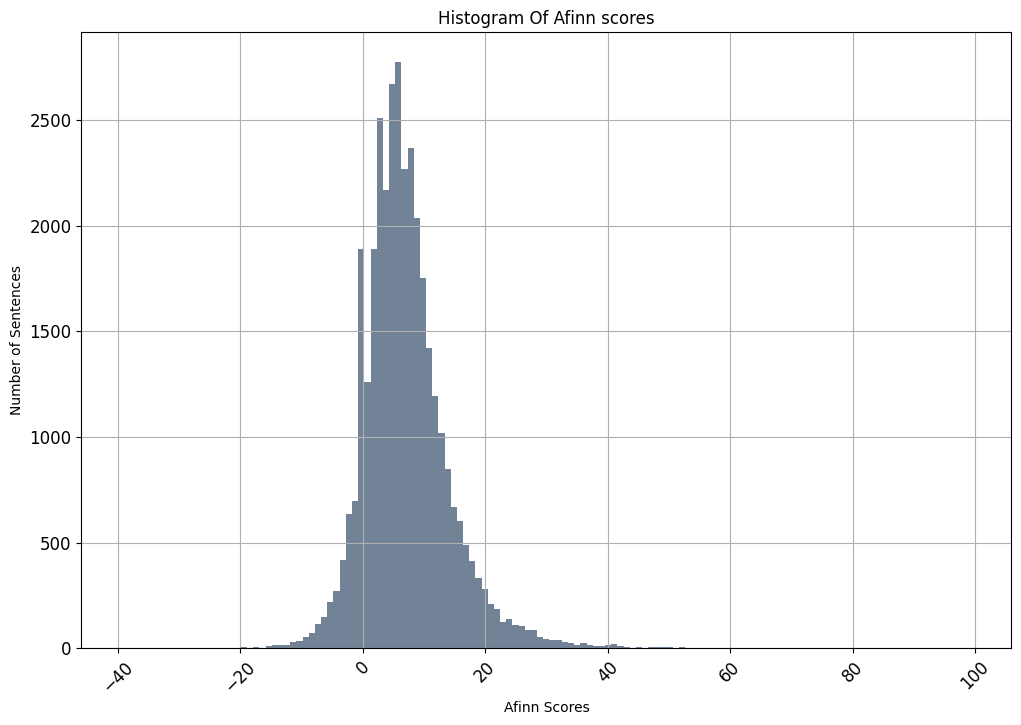

In [19]:
df.afinn.plot(kind='hist', #takes the column name as input
        alpha=0.7,
        bins = abs(min(df.afinn.value_counts().index.astype(int)) - max(df.afinn.value_counts().index.astype(int)))-1,
        title='Histogram Of Afinn scores',
        rot=45,
        grid=True,
        figsize=(12,8),
        fontsize=12, 
        color=['#364F6B'])
plt.xlabel('Afinn Scores')
plt.ylabel("Number of Sentences");

In [20]:
#let's check the distribution of sentiment values

In [21]:
df.score.value_counts() #df. column_name .value_counts()

2    27004
0     5218
1     2855
Name: score, dtype: int64

In [22]:
confusion = pd.crosstab(df.score, df.afinn) #confusion matrix
confusion

afinn,-39.0,-28.0,-26.0,-25.0,-24.0,-23.0,-22.0,-21.0,-20.0,-19.0,...,55.0,57.0,59.0,61.0,62.0,63.0,66.0,69.0,97.0,99.0
score,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,2,2,2,2,4,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,1,2,1,0,1,0,1,1,1,1


compute a 3-class confusion matrix 
- positive (+1) 
- neutral (0) 
- negative (-1)

In [23]:
# Compute 3-class confusion matrix
confusion = pd.crosstab(np.sign(df.score - 1), 
                        np.sign(df.afinn))
confusion

afinn,-1.0,0.0,1.0
score,,,
-1,1504,582,3132
0,303,247,2305
1,962,1062,24980


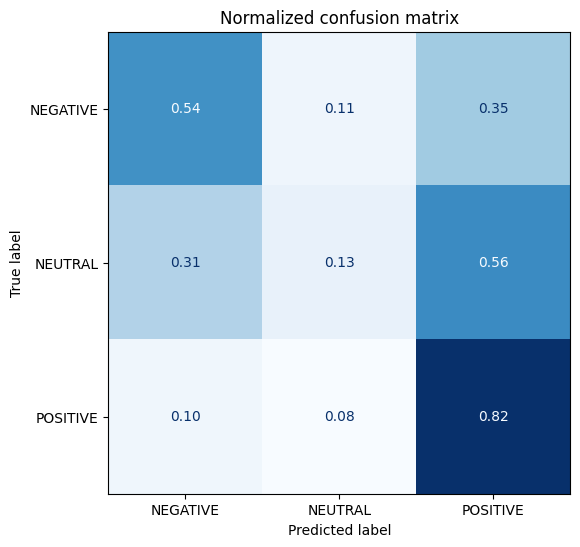

In [24]:

plot_confusion_matrix(np.sign(df.score - 1), np.sign(df.afinn))

In [25]:
accuracy_3_class = np.sum(np.diag(confusion)) / np.sum(confusion.values)
accuracy_3_class

0.7620663112580893

## Feature Engeneering and standard ML classifiers


In [25]:
df.score.value_counts()

2    27004
0     5218
1     2855
Name: score, dtype: int64

In [26]:
def balance_by_score(score_value, number_of_instances, data):
  return data[data == score_value].sample(number_of_instances, random_state=1).index.to_list()

In [27]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, random_state=1, test_size=0.2)
train_df

,text,score,afinn
9968,"[switched, similac, advanced, organic, daughte...",2,2.0
1999,"[we, use, farmhouse, pancake, waffle, mix, mak...",2,3.0
13161,"[love, good, cup, coffee, amp, scent, one, bes...",1,49.0
30709,"[pop, chips, delicious, light, tasty, bought, ...",2,5.0
26114,"[addicted, salty, tangy, flavors, opened, firs...",2,19.0
...,...,...,...
7813,"[went, gourmet, store, asked, chocolate, exper...",2,4.0
32511,"[ordered, decorations, lemon, lavendar, cupcak...",2,5.0
5192,"[yuban, makes, best, cup, coffee, either, roas...",2,21.0
12172,"[happy, found, product, amazon, my, dog, loves...",2,15.0


### Balancing

[]

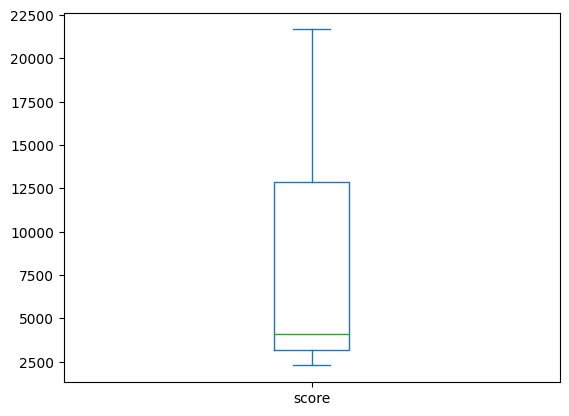

In [28]:
b_plot = train_df.score.value_counts().plot.box() 
b_plot.plot()

In [29]:
train_df.score.value_counts()

2    21671
0     4105
1     2285
Name: score, dtype: int64

In [30]:
train_df.score.value_counts().describe()

count        3.000000
mean      9353.666667
std      10705.868733
min       2285.000000
25%       3195.000000
50%       4105.000000
75%      12888.000000
max      21671.000000
Name: score, dtype: float64

In [31]:
def balance_by_label(label_value, number_of_instances, data):
  l = data[data.score == label_value].score.value_counts().to_numpy()[0]
  if l >= number_of_instances:
    return data[data.score == label_value].sample(number_of_instances, random_state=1)#.index.to_list()
  else:
    return data[data.score == label_value].sample(number_of_instances, random_state=1, replace=True)#.index.to_list()


In [32]:
sampling_value = int(train_df.score.value_counts().describe(include='all').loc['25%']) # 25th percentiles

In [33]:
new_train_df = balance_by_label(0, sampling_value,train_df)

for i in range(1,NUM_CLASSES):
  output = balance_by_label(i, sampling_value,train_df)  
  new_train_df = pd.concat([new_train_df, output])

new_train_df.score.value_counts()


0    3195
1    3195
2    3195
Name: score, dtype: int64

In [34]:
train_df = new_train_df

In [35]:
train_df = train_df[["text", "score"]].reset_index(drop=True)
train_df

,text,score
0,"[must, say, bummed, bought, pack, artificially...",0
1,"[we, year, old, pug, eat, anything, unfortunat...",0
2,"[got, drink, expecting, carbonated, taste, com...",0
3,"[so, soon, delivery, guy, gave, package, opene...",0
4,"[really, like, coffee, i'll, dammed, going, pa...",0
...,...,...
9580,"[we, week, old, he, gas, constipation, problem...",2
9581,"[using, shake, bake, products, long, time, nea...",2
9582,"[when, read, reviews, noticed, someone, mentio...",2
9583,"[our, pups, love, eat, right, please, note, po...",2


In [36]:
X_train = train_df.text
y_train = train_df.score
X_test = test_df.text
y_test = test_df.score

y_train, y_test

(0       0
 1       0
 2       0
 3       0
 4       0
        ..
 9580    2
 9581    2
 9582    2
 9583    2
 9584    2
 Name: score, Length: 9585, dtype: int64,
 5109     2
 15653    2
 1390     2
 24565    2
 4613     2
         ..
 24589    2
 4069     0
 4576     0
 28054    2
 12329    1
 Name: score, Length: 7016, dtype: int64)

In [37]:
cond = train_df['text'].str.contains(r'^\s*$', na=False)
cond[cond==True].index.to_list()

[]

### BoW

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

#Step 2-3: Pre-process and Vectorize train and test data
vect = CountVectorizer(stop_words=None, lowercase=True, max_features=5000)
#clean is a function we defined for pre-processing, seen in the notebook.
X_train_dtm = vect.fit_transform(X_train.apply(lambda x: " ".join(x)))
X_test_dtm = vect.transform(X_test.apply(lambda x: " ".join(x)))
print(X_train_dtm.shape, X_test_dtm.shape)

(9585, 5000) (7016, 5000)


In [39]:
from sklearn.metrics import f1_score
def analisys(y_test, y_pred_class):
  print("\n Accuracy: ", accuracy_score(y_test, y_pred_class))
  print("Report: \n",classification_report(y_test, y_pred_class))
  plot_confusion_matrix(y_pred_class, y_test)


def plot_confusion_matrix(y_preds, y_true):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[score_to_sentiment[x] for x in range(NUM_CLASSES)])
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()



In [40]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

def svm_classifier(X_train_balanced, y_train_balanced, X_ts, y_ts):
  classifier = LinearSVC() 
  classifier.fit(X_train_balanced, y_train_balanced) #fit the model with training data
  y_pred_class = classifier.predict(X_ts)
  analisys(y_ts, y_pred_class)

def mnb_classifier(X_train_balanced, y_train_balanced, X_ts, y_ts):
  nb = MultinomialNB() #instantiate a Multinomial Naive Bayes classifier
  nb.fit(X_train_balanced, y_train_balanced)#train the mode
  y_pred_class = nb.predict(X_ts)#make class predictions for test data
  analisys(y_ts, y_pred_class)

def lr_classifier(X_train_balanced, y_train_balanced, X_ts, y_ts):
  logreg = LogisticRegression(max_iter=10000)
  logreg.fit(X_train_balanced, y_train_balanced)
  y_pred_class = logreg.predict(X_ts)
  analisys(y_ts, y_pred_class)


### Balancig Data

https://imbalanced-learn.org/stable/

In [41]:
!pip install imbalanced-learn
from imblearn.over_sampling import *
from imblearn.under_sampling import *
from imblearn.combine import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
def balancing_data(method, X_train_not_balanced, y_train_not_balanced):
  autopct = "%.2f"
  fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
  y_train_not_balanced.value_counts().plot.pie(autopct=autopct, ax=axs[0])
  axs[0].set_title("Original")
  X_train_balanced, y_train_balanced = method.fit_resample(X_train_not_balanced, y_train_not_balanced)
  y_train_balanced.value_counts().plot.pie(autopct=autopct, ax=axs[1])
  axs[1].set_title("Balanced")
  fig.tight_layout()
  print(y_train_balanced.value_counts())
  return X_train_balanced, y_train_balanced

In [43]:
# X_train_balanced, y_train_balanced = balancing_data(BorderlineSMOTE(random_state=42), X_train_dtm, y_train)

### Naive Bayes Classifier



 Accuracy:  0.7146522234891676
Report: 
               precision    recall  f1-score   support

           0       0.50      0.68      0.58      1113
           1       0.20      0.42      0.27       570
           2       0.93      0.75      0.83      5333

    accuracy                           0.71      7016
   macro avg       0.55      0.62      0.56      7016
weighted avg       0.81      0.71      0.75      7016



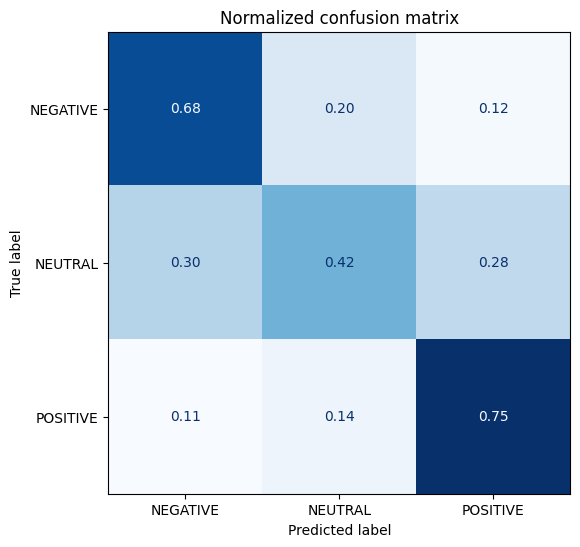

In [44]:
mnb_classifier(X_train_dtm, y_train, X_test_dtm, y_test)

### Logistic Regression



 Accuracy:  0.7182155074116305
Report: 
               precision    recall  f1-score   support

           0       0.52      0.68      0.59      1113
           1       0.20      0.44      0.28       570
           2       0.93      0.76      0.84      5333

    accuracy                           0.72      7016
   macro avg       0.55      0.62      0.57      7016
weighted avg       0.81      0.72      0.75      7016



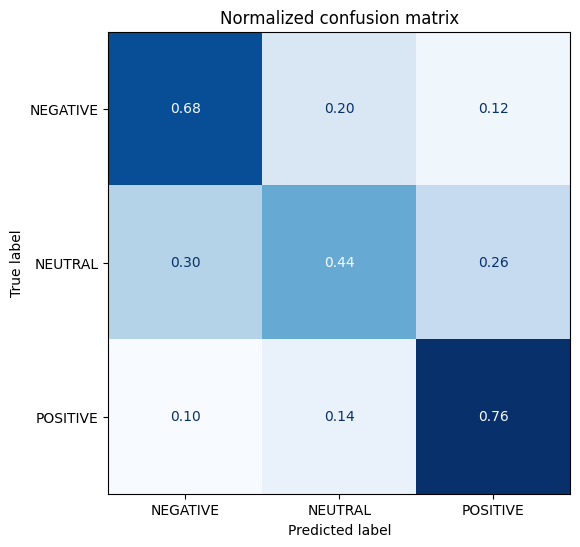

In [45]:
lr_classifier(X_train_dtm, y_train, X_test_dtm, y_test)

### Support Vector Machine



 Accuracy:  0.6962656784492588
Report: 
               precision    recall  f1-score   support

           0       0.48      0.67      0.56      1113
           1       0.19      0.42      0.27       570
           2       0.93      0.73      0.82      5333

    accuracy                           0.70      7016
   macro avg       0.53      0.61      0.55      7016
weighted avg       0.80      0.70      0.73      7016



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


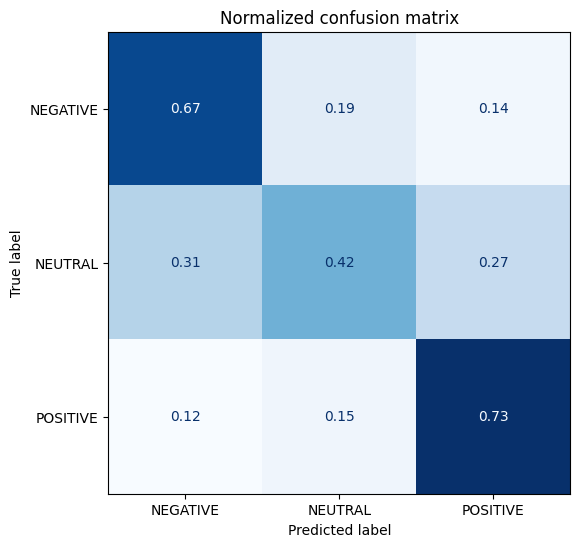

In [46]:
svm_classifier(X_train_dtm, y_train, X_test_dtm, y_test)

## Using Neural Embeddings in Text Classification


### Word Embeddings
We use [GoogleNews-vectors-negative300](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g). This is a large model that can be seen as a dictionary where the keys are words in the
vocabulary and the values are their learned embedding representations. Given a
query word, if the word’s embedding is present in the dictionary, it will return the
same

In [47]:
data_path= PATH_PROJ + "GoogleNews-vectors-negative300.bin" # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?resourcekey=0-wjGZdNAUop6WykTtMip30g
# !cp $data_path "/content/GoogleNews-vectors-negative300.bin"

In [48]:
from gensim.models import KeyedVectors

#Load W2V model. This will take some time.
w2v_model = KeyedVectors.load_word2vec_format(data_path, binary=True)
print('done loading Word2Vec')

done loading Word2Vec


How do we use this pre-learned embedding to represent features? A simple approach is just
to average the embeddings for individual words in text.

In [49]:
import math
# Creating a feature vector by averaging all embeddings for all sentences
def embedding_feats(list_of_lists, w2v_model):
  DIMENSION = 300
  zero_vector = np.zeros(DIMENSION)
  feats = []
  for tokens in list_of_lists:
    feat_for_this = np.zeros(DIMENSION)
    count_for_this = 0
    
    for token in tokens:
      if token in w2v_model:
        feat_for_this += w2v_model[token]
        count_for_this +=1
    
    
    if count_for_this != 0:
      feats.append(feat_for_this/count_for_this)
    else:
      feats.append(np.zeros(DIMENSION))
    
  return feats

In [50]:
train_vectors = embedding_feats(X_train, w2v_model)
print(len(train_vectors))
test_vectors = embedding_feats(X_test, w2v_model)
print(len(test_vectors))

9585
7016


In [51]:
# X_train_balanced, y_train_balanced = balancing_data(BorderlineSMOTE(random_state=42), train_vectors, y_train)

In [52]:
np.argwhere(np.isnan(np.array(train_vectors)))

array([], shape=(0, 2), dtype=int64)

We treat the resulting
embedding vector as the feature vector that represents the entire text. Once this feature engineering is done, the final step is similar to what we did in the previous section: use these features and train a classifier. 


### Naive Bayes Classifier

Naive bayes classifier does not allow for negative values in the document vectors. But when we use document+word vectors, Z will have some negatives. It should be possible to translate/scale all vectors uniformly to avoid negatives, but we do not bother as we have enough simulations to run anyway. So basically naive bayes classifier is used ONLY with pure document vectors here.

credits: https://towardsdatascience.com/word-embeddings-and-document-vectors-when-in-doubt-simplify-8c9aaeec244e


 Accuracy:  0.5565849486887116
Report: 
               precision    recall  f1-score   support

           0       0.31      0.61      0.41      1113
           1       0.15      0.43      0.22       570
           2       0.93      0.56      0.70      5333

    accuracy                           0.56      7016
   macro avg       0.46      0.53      0.44      7016
weighted avg       0.77      0.56      0.61      7016



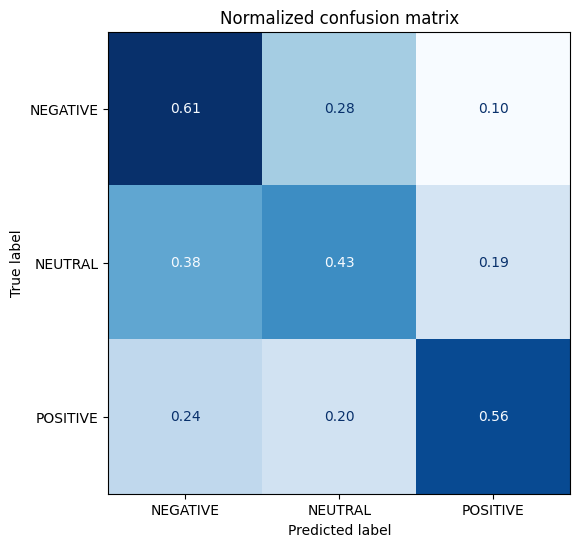

In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_balanced_for_mnb = scaler.fit_transform(train_vectors)
X_ts_for_mnb = scaler.transform(test_vectors)


mnb_classifier(X_train_balanced_for_mnb, y_train, X_ts_for_mnb, y_test)

### Logistic Regression



 Accuracy:  0.669612314709236
Report: 
               precision    recall  f1-score   support

           0       0.47      0.66      0.55      1113
           1       0.18      0.47      0.26       570
           2       0.94      0.69      0.80      5333

    accuracy                           0.67      7016
   macro avg       0.53      0.61      0.53      7016
weighted avg       0.80      0.67      0.71      7016



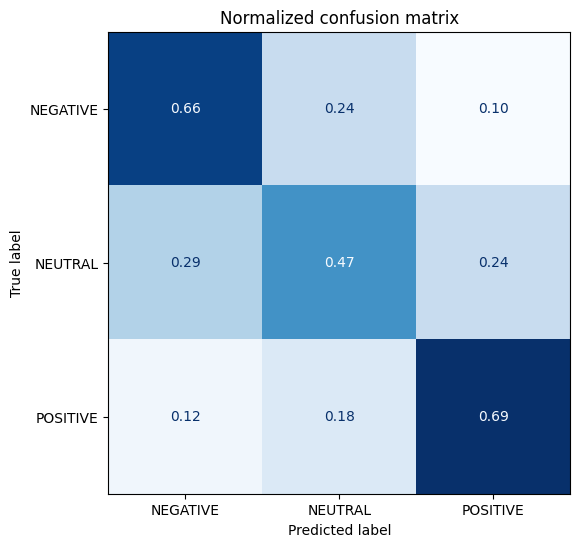

In [54]:
lr_classifier(train_vectors, y_train, test_vectors, y_test)

### Support Vector Machine



 Accuracy:  0.6785917901938426
Report: 
               precision    recall  f1-score   support

           0       0.47      0.66      0.55      1113
           1       0.18      0.45      0.26       570
           2       0.93      0.71      0.80      5333

    accuracy                           0.68      7016
   macro avg       0.53      0.61      0.54      7016
weighted avg       0.80      0.68      0.72      7016



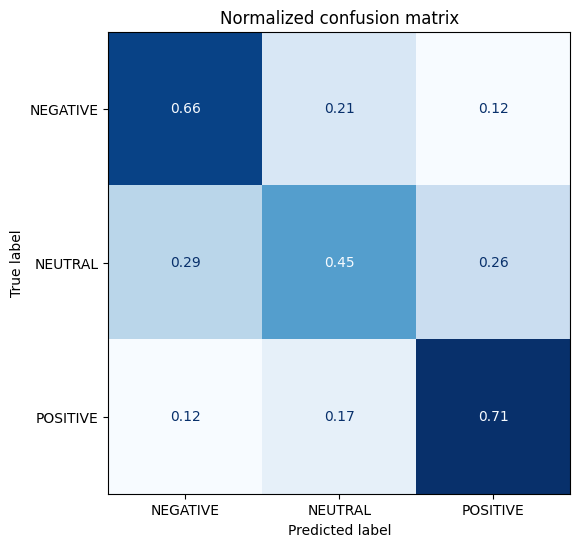

In [55]:
svm_classifier(train_vectors, y_train, test_vectors, y_test)

In [56]:
!pip install fasttext==0.9.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393183 sha256=8ea5d593b111e8b064b85ad89ae84fa7f446a9130756690a957cb702c65612ed
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [57]:
PATH_PROJ = "/content/drive/MyDrive/data-proj/"
# if not os.path.exists(PATH_PROJ):
#   PATH_PROJ = "/content/drive/MyDrive/shared/data-proj/"

PATH_DATASET = PATH_PROJ+"food.csv"
PATH_DATASET_FIRST_PREPROCESSING = PATH_PROJ+"first_preprocessing.csv"
NUM_CLASSES=3
score_to_sentiment = {
    0: "NEGATIVE",
    1: "NEUTRAL",
    2: "POSITIVE"
}

In [58]:
df = pd.read_csv(PATH_DATASET_FIRST_PREPROCESSING)[["text","score"]]#.sample(frac=0.2).reset_index(drop=True) # sampling a fraction of 20% to speed process
df_tmp = df.copy()
df

,text,score
0,I have bought several of the Vitality canned d...,2
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,2
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,2
...,...,...
35167,"Once I tasted Hazelnut coffee, I was hooked! N...",2
35168,Has Maxwell House quit making this coffee? I ...,2
35169,"Nutty, smooth, subtle, with a WONDERFUL aroma-...",2
35170,Price was right and the taste very good. We w...,2


In [59]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=1)

In [60]:
train, validation = train_test_split(train, test_size=0.2, random_state=1)

In [61]:
train_df = train.reset_index(drop=True)
train_df

,text,score
0,"My husband loves pop chips, as a low-fat alter...",2
1,"I ordered the French Vanilla, the only creamer...",2
2,I love this soup. Great to put into the crockp...,2
3,My dogs loved them. I'm not sure if it's helpe...,2
4,These things are great - I discovered them at ...,2
...,...,...
22504,This is the perfect product to get that movie-...,2
22505,"Our local TJ's used to carry these, but no mor...",2
22506,I have been taste-testing so many brands and r...,2
22507,Crunchy. Came packaged well. If you are thin...,1


In [62]:
validation_df = validation.reset_index(drop=True)
validation_df

,text,score
0,I wish I had read the product description bett...,0
1,I ordered a set of three cans and they showed ...,2
2,"I love the idea of champagne truffles, but the...",0
3,"Of course, it's a taste opinion. I gave it fo...",2
4,This food is so full of chunks that my cats ju...,2
...,...,...
5623,As someone who lives and dies by seafood I've ...,1
5624,Organic Chocolate Green SuperFood is one of th...,2
5625,Fantastic product. Keeps fresh for months. Had...,2
5626,I tried the Frooties mBerry and the effect las...,0


In [63]:
test_df = test.reset_index(drop=True)
test_df

,text,score
0,I really like Nantucket Blend. I drink way to...,0
1,"Hi, i ordered this product from another websit...",1
2,"Smooth coffee with rich, flavorful aroma, alon...",0
3,Fondarific usually has glowing reviews... ever...,0
4,"The price was awesome, the shipping was incred...",2
...,...,...
7030,Love these pop-chips! The variety bag was a gr...,2
7031,"I like the idea behind this product, but the t...",1
7032,I have been giving these chews to my Mini-Pinc...,0
7033,We brought this product home from Jamaica and ...,2


In [64]:
b_plot = train_df.label.value_counts().plot.box() 
b_plot.plot()

AttributeError: ignored

In [ ]:
train_df.label.value_counts()

In [ ]:
train_df.label.value_counts().describe()

In [ ]:
def balance_by_label(label_value, number_of_instances, data):
  l = data[data.label == label_value].label.value_counts().to_numpy()[0]
  if l >= number_of_instances:
    return data[data.label == label_value].sample(number_of_instances, random_state=1)#.index.to_list()
  else:
    return data[data.label == label_value].sample(number_of_instances, random_state=1, replace=True)#.index.to_list()


In [ ]:
sampling_value = int(train_df.label.value_counts().describe(include='all').loc['25%']) # 25th percentiles

In [ ]:
new_train_df = balance_by_label(0, sampling_value,train_df)

for i in range(1,NUM_CLASSES):
  output = balance_by_label(i, sampling_value,train_df)  
  new_train_df = pd.concat([new_train_df, output])

new_train_df.label.value_counts()


In [ ]:
train_df = new_train_df

In [ ]:
train_df = train_df[["text", "label"]].reset_index(drop=True)
train_df

So, the first step
involves cleaning the text to
remove extraneous characters, similar to what we did in the pre-processing steps for
the other classifier examples we’ve seen so far.

In [ ]:
# Lets do some cleaning of this text
def clean_it(text,normalize=True):
    # Replacing possible issues with data. We can add or reduce the replacemtent in this chain
    s = str(text).replace(',',' ').replace('"','').replace('\'',' \' ').replace('.',' . ').replace('(',' ( ').\
            replace(')',' ) ').replace('!',' ! ').replace('?',' ? ').replace(':',' ').replace(';',' ').lower()
    
    # normalizing / encoding the text
    if normalize:
        s = s.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')
    
    return s

# Now lets define a small function where we can use above cleaning on datasets
def clean_df(data, cleanit= False, shuffleit=False, encodeit=False, label_prefix='__class__'):
    # Defining the new data
    df = data[['text']].copy(deep=True)
    df['score'] = label_prefix + data['score'].astype(str) + ' '
    
    # cleaning it
    if cleanit:
        df['text'] = df['text'].apply(lambda x: clean_it(x,encodeit))
    
    # shuffling it
    if shuffleit:
        df.sample(frac=1).reset_index(drop=True)
            
    return df

In [ ]:
df_train_cleaned = clean_df(train_df, True, True)
df_train_cleaned

In [ ]:
df_test_cleaned = clean_df(test_df, True, True)
df_test_cleaned

In [ ]:
# Write files to disk as fastText classifier API reads files from disk.
train_file = PATH_PROJ + '/fasttext_train.csv'
test_file = PATH_PROJ + '/fasttext_test.csv'

In [ ]:

df_train_cleaned.to_csv(train_file, header=None, index=False, columns=['score','text'] )

df_test_cleaned.to_csv(test_file, header=None, index=False, columns=['score','text'])

Now that we have the train and test files written into disk in a format fastText wants, we are ready to use it for text classification!

In [ ]:
%%time
## Using fastText for feature extraction and training
from fasttext import train_supervised 
"""fastText expects and training file (csv), a model name as input arguments.
label_prefix refers to the prefix before label string in the dataset.
default is __label__. In our dataset, it is __class__. 
There are several other parameters which can be seen in: 
https://pypi.org/project/fasttext/
"""

model = train_supervised(input=train_file, label="__class__", lr=1.0, epoch=75, loss='ova', wordNgrams=2, dim=200, thread=2, verbose=100)

In [ ]:
def f1_score_compute(precision, recall):
  return 2 * (precision * recall) / (precision + recall)

# Precision = True Positive / (True Positive + False Positive) 
# Recall = True Positive / (True Positive + False Negative) 
# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

k=1
results = model.test(test_file,k=k) # you should specify k parameter to get the top-k predicted classes. DOC: https://fasttext.cc/docs/en/supervised-tutorial.html#advanced-readers-precision-and-recall
recall = results[2]*100
precision = results[1]*100
f1 = f1_score_compute(precision, recall)
print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}  --- F1_score@{k}: {f1}")

In [ ]:
from sklearn.metrics import confusion_matrix

# predict the data
df_test_cleaned["predicted"] = df_test_cleaned["text"].apply(lambda x: model.predict(x)[0][0])

# Create the confusion matrix
confusion_matrix(df_test_cleaned["score"], df_test_cleaned["predicted"])
